# Домашняя работа: "Методы оптимизации"

**ФИО: Бекетов Роман Александровчи**

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 9 октября.

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

In [37]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Часть 1: Реализация методов

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

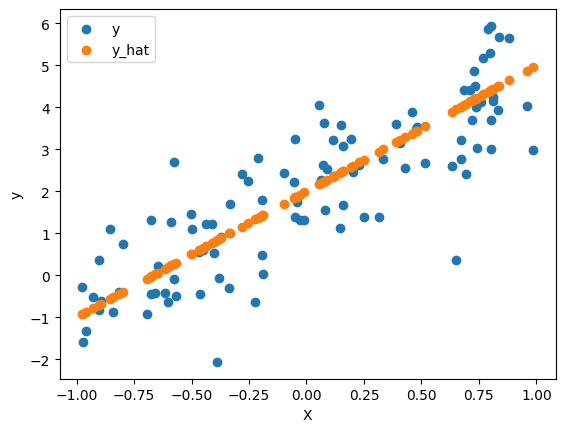

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

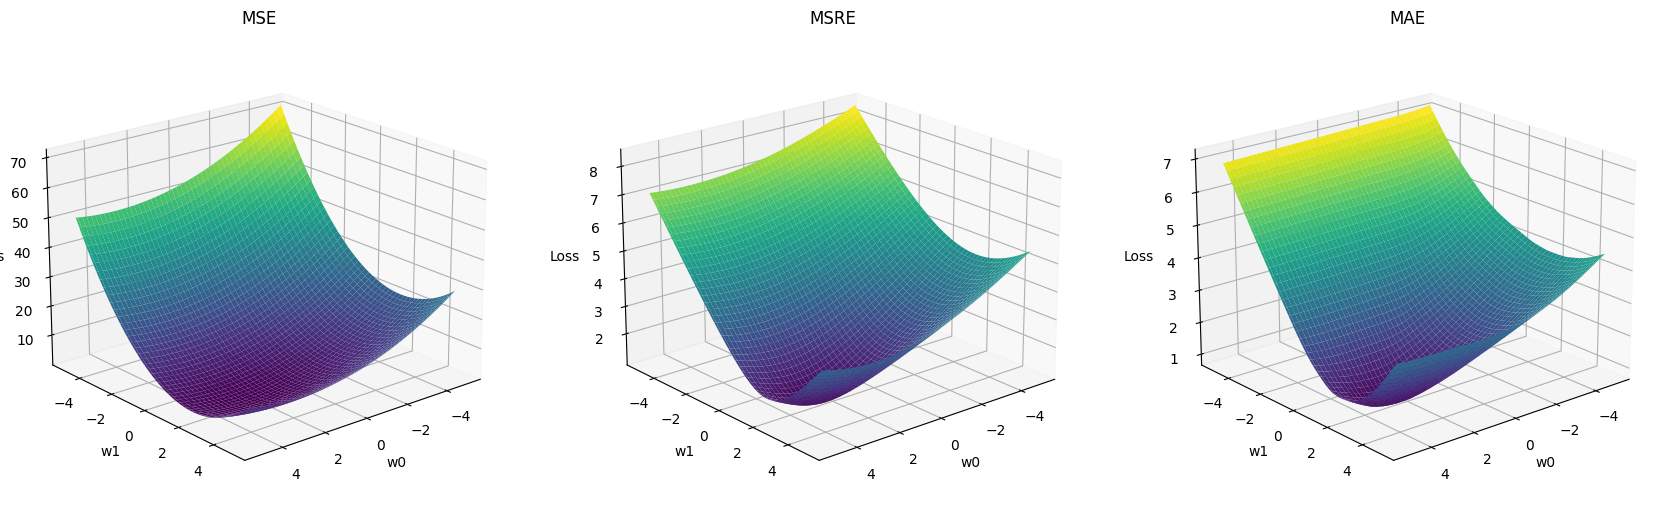

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)

    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [9]:
class AdaGrad(Optimizer):
    def __init__(self, params, eta=1e-8, nu=1e-2):
        super().__init__(params)
        self.eta = eta
        self.nu = nu

        self.G = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.nu / torch.sqrt(self.G[i] + self.eta) * p.grad

In [10]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.momentum[i]
                self.momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.momentum[i] - self.gamma * prev_momentum

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
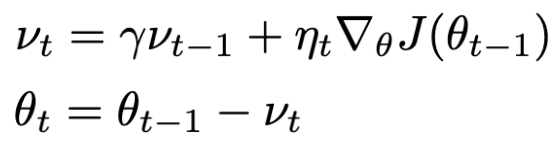

In [11]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.gamma = gamma
        self.lr = lr
        
        self.v = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                
                self.v[i] = self.gamma * self.v[i] + self.lr*p.grad
                p -= self.v[i]
                

In [12]:
# MY NAG with pre_step
class MyNAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.gamma = gamma
        self.lr = lr
        
        self.v = [torch.zeros(p.shape) for p in self.params]
    
    def pre_step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                p -= self.gamma * self.v[i]
    
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                p += self.gamma * self.v[i]
                self.v[i] = self.gamma * self.v[i] + self.lr*p.grad
                p -= self.v[i]
                

#### AdaDelta
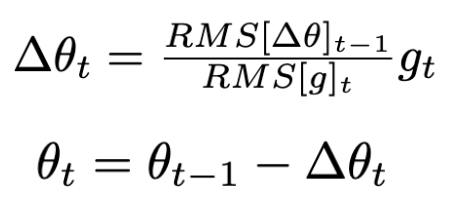

In [57]:
class AdaDelta(Optimizer):
    def __init__(self, params, eta=1e-6, gamma=0.9, lr=1.0):
        super().__init__(params)
        self.eta = eta
        self.gamma = gamma
        self.lr = lr
        
        self.G = [torch.zeros(p.shape, device=device) for p in self.params]
        self.O = [torch.zeros(p.shape, device=device) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                deltaP = (torch.sqrt(self.O[i] + self.eta) / torch.sqrt(self.G[i] + self.eta)) * p.grad
                self.O[i] = self.gamma * self.O[i] + (1 - self.gamma) * (deltaP ** 2)
                p -= self.lr * deltaP

#### Adam
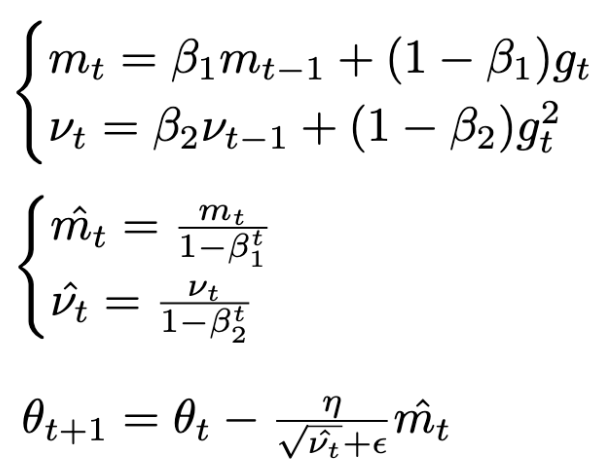

In [52]:
class Adam(Optimizer):
    def __init__(self, params, b1=0.9, b2=0.999, lr=1e-3, eta=1e-8):
        super().__init__(params)
        self.b1 = b1
        self.b2 = b2
        self.lr = lr
        self.eta = eta
        
        self.m = [torch.zeros(p.shape, device=device) for p in self.params]
        self.v = [torch.zeros(p.shape, device=device) for p in self.params]
        self.t = 1

    def zero_step(self):
        self.t = 1

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.m[i] = self.b1 * self.m[i] + (1 - self.b1) * p.grad
                self.v[i] = self.b2 * self.v[i] + (1 - self.b2) * (p.grad**2)
                m_correct = self.m[i] / (1 - self.b1**self.t)
                v_correct = self.v[i] / (1 - self.b2**self.t)
            
                p -= self.lr*m_correct / (torch.sqrt(v_correct) + self.eta)
                
            self.t += 1

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [15]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), Adam, {'lr': 1e-3, 'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [70]:
device = torch.device("cpu")
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', Momentum, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta': 1e-8, 'nu' : 1}],
        ['AdaDelta', AdaDelta, {'gamma': 0.9, 'eta': 1e-6, 'lr': 300}],
        ['NAG', NAG, {'gamma': 0.9, 'lr': 1e-1}],
        ['Adam', Adam, {'b1': 0.9, 'b2': 0.999, 'lr': 0.5, 'eta': 1e-8}]
     ],
    start_point=[-4, -4],
    num_iter=100
)

/opt/conda/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/opt/conda/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [17]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2023-10-01 22:00:13--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-10-01 22:00:13--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [         <=>        ]  33.20M  7.71MB/s    in 5.1s    

2023-10-01 22:00:19 (6.46 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [19]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [21]:
device

device(type='cuda')

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [60]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=1, padding=2)
        self.dropuot2d = nn.Dropout2d(0.5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), stride=1, padding=2)
        self.fc1 = nn.Linear(7*7*32, 1024)
        self.dropuot = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.dropuot2d(F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2), stride=(2,2)))
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2), stride=(2,2))
        x = torch.flatten(x, 1)
        x = self.dropuot(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x)

In [61]:
network = Net()
optimizer = Adam(network.parameters(), lr=1e-3)

In [62]:
print(network)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropuot2d): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=1024, bias=True)
  (dropuot): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


Запустите обучение, постройте график лоссов от эпохи:

In [63]:
def train(network, optimizer):
    losses = []
    network.train()

    if hasattr(optimizer, 'zero_step'):
        optimizer.zero_step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            1, batch_idx * len(data), len(train_loader.dataset),
             100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.cpu().item())
    return losses


In [27]:
def show_plot_losses(losses, names):
    plt.figure(figsize=(12, 5))
    
    for name, loss in zip(names, losses):
        plt.plot(loss, label=name)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid(True)
    plt.show()

In [28]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

/tmp/ipykernel_28/317909214.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335665
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.356143
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.827594
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.631997
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.358425
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.934758
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.213729
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.141445
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.429934
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.205487
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.178216
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.327866
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.327245
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.051735
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.237662
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.144720
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.269450
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.143454
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.100916


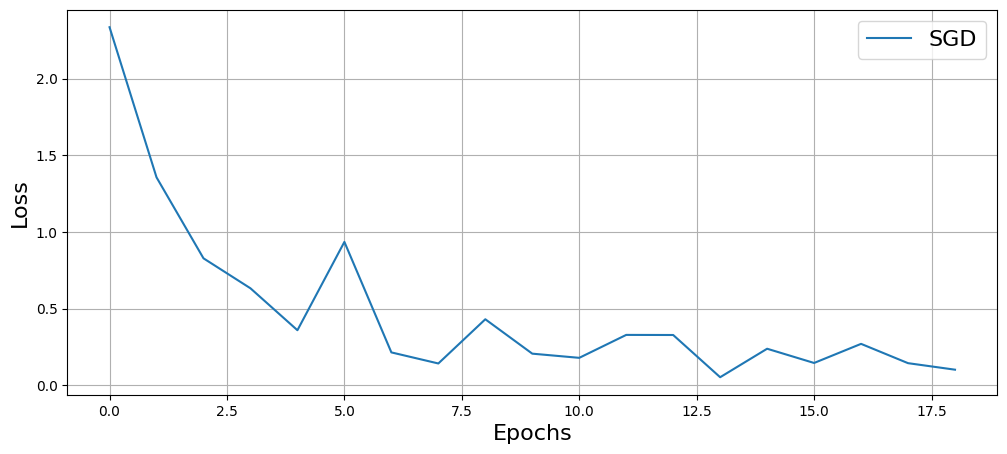

In [64]:
network = Net()
network.to(device)
losses_sgd = train(network, SGD(network.parameters()))
show_plot_losses([losses_sgd], ['SGD'])

/tmp/ipykernel_28/317909214.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.409953
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.328741
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.293630
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.209628
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.332110
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.140640
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.399293
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.354028
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.066589
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.018743
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.101874
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.092941
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.057515
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.141230
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.107753
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.018129
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.025910
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.050255
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.285359


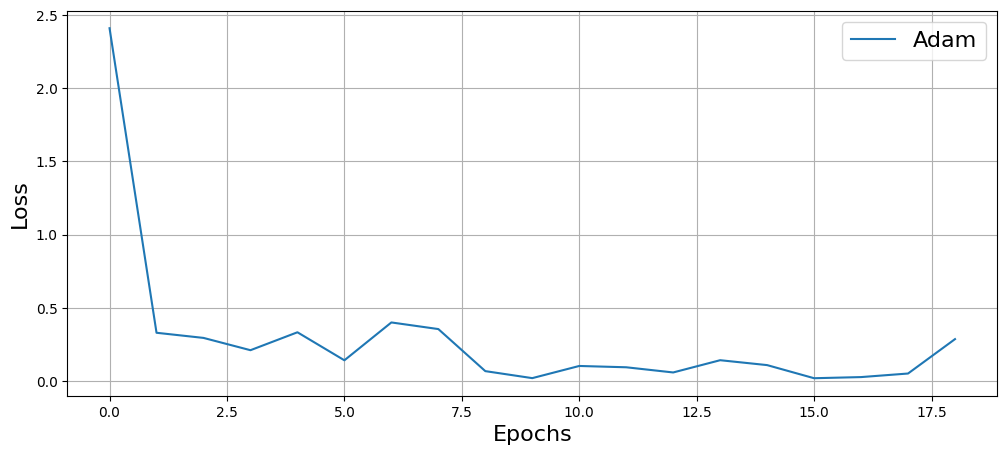

In [65]:
network = Net()
network.to(device)
losses_adam = train(network, Adam(network.parameters(), lr=1e-3))
show_plot_losses([losses_adam], ['Adam'])

/tmp/ipykernel_28/317909214.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.289901
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.583884
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.383194
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.385590
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.102621
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.139805
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.187728
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.124552
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.074882
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.132476
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.165173
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.092885
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.248634
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.077341
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.016391
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.334037
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.023477
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.081596
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.120925


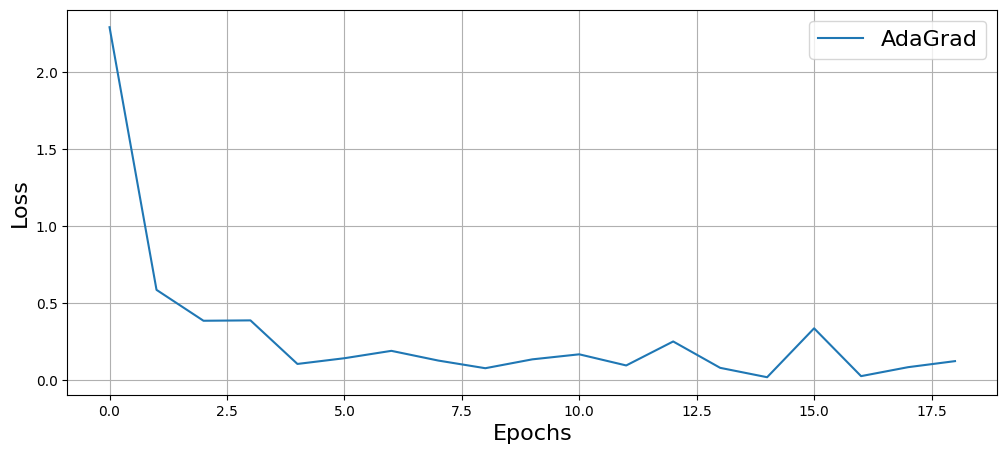

In [66]:
network = Net()
network.to(device)
losses_ada_grad = train(network, AdaGrad(network.parameters()))
show_plot_losses([losses_ada_grad], ['AdaGrad'])

/tmp/ipykernel_28/317909214.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300834
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.481525
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.188232
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.054608
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.093345
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.059471
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.292094
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.236700
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.457717
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.112326
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.368020
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.084604
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.202482
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.130212
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.129141
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.092564
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.280587
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.039406
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.152295


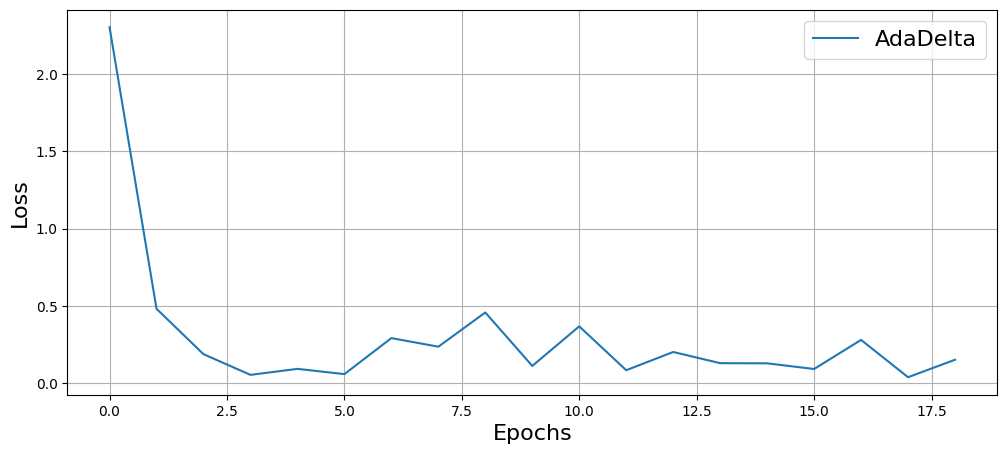

In [67]:
network = Net()
network.to(device)
losses_ada_delta = train(network, AdaDelta(network.parameters()))
show_plot_losses([losses_ada_delta], ['AdaDelta'])

### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

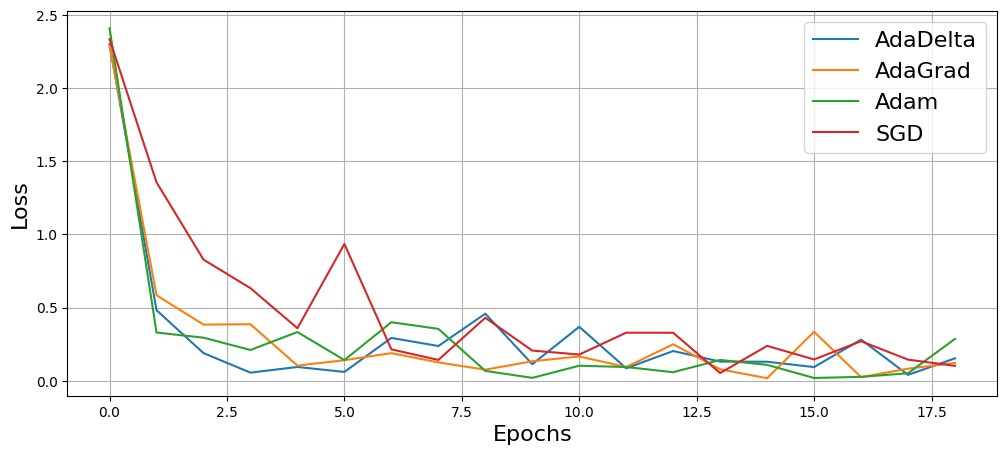

In [68]:
show_plot_losses([losses_ada_delta, losses_ada_grad, losses_adam, losses_sgd], ['AdaDelta', 'AdaGrad', 'Adam', 'SGD'])

***Сравнение***:
На MNISTе с данной архитектурой нейронной сети адаптивные методы показывают себя чуточку лучше SGD. Сильной разницы между адаптивными методами не было замечено. Однако Adam - это один из наиболее популярных и эффективных оптимизаторов. Adam сочетает преимущества AdaGrad и RMSprop и зачастую является наиболее эффективным и универсальным инструментом.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

Хотелось бы получить разбор написания NAG поподробнее: откуда появилась данная формула и как её получить =)